<a href="https://colab.research.google.com/github/PValsted/MLA_PV/blob/main/MLA2_PV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Machine Learning Assignment 2 #  
**Patrick Valsted**  

## Standard Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Imports for specific models
In this section, you will import the models from SKLearn that you will use this in this notebook.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

## Imports for Splitting Data and Building Pipeline


In [4]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Imports for Performance Measures

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

## Confusion Matrix Function
This function is for creating a graphical version of the confusion matrix.



In [6]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    fig = plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

# ROC_Curve Function
This function is for plotting the roc_curve

In [7]:
def plot_roc_curve(fpr,tpr):
  plt.plot(fpr, tpr, linewidth=2)
  plt.plot([0,1],[0,1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])

## Problem 1

### Reading the Data

In [8]:
df=pd.read_csv('/content/gdrive/MyDrive/CS430/Steel_industry_data.csv')

In [9]:
df.rename(columns={'Usage_kWh':'usage_kwh', 'Lagging_Current_Reactive.Power_kVarh':'lag_react_pwr_kvarh','Leading_Current_Reactive_Power_kVarh':'lead_react_pwr_kvarh',
                   'Lagging_Current_Power_Factor':'lag_current_pwr','Leading_Current_Power_Factor':'lead_current_pwr','NSM':'nsm','WeekStatus':'week_status',
                   'Day_of_week':'day_of_week','Load_Type':'load_type'},inplace=True)

### Statistical and Visual Exploration

In [10]:
df.describe()

,usage_kwh,lag_react_pwr_kvarh,lead_react_pwr_kvarh,CO2(tCO2),lag_current_pwr,lead_current_pwr,nsm
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


In [11]:
df.head()

,date,usage_kwh,lag_react_pwr_kvarh,lead_react_pwr_kvarh,CO2(tCO2),lag_current_pwr,lead_current_pwr,nsm,week_status,day_of_week,load_type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [12]:
load = df['load_type'].groupby(df['load_type']).count()

In [13]:
load

load_type
Light_Load      18072
Maximum_Load     7272
Medium_Load      9696
Name: load_type, dtype: int64

<Axes: title={'center': 'Number of Loads by Type'}, xlabel='load_type'>

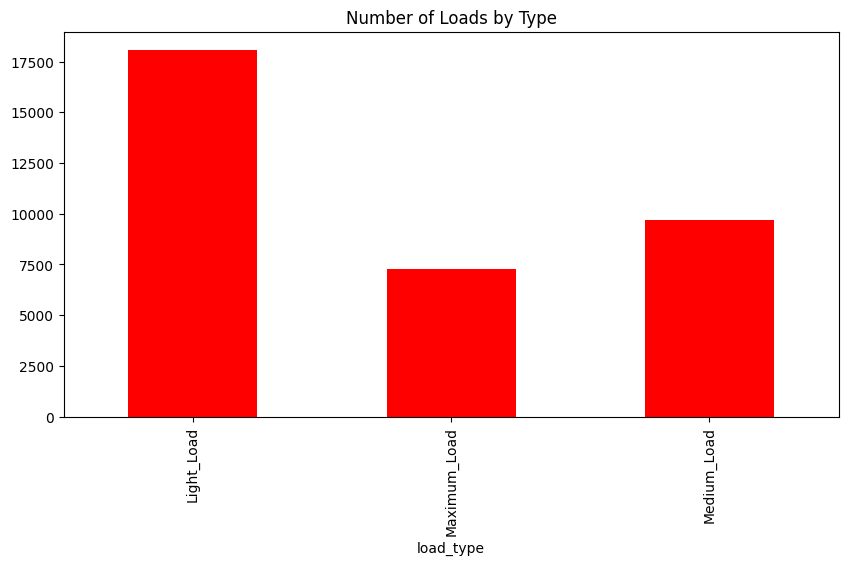

In [14]:
load.plot(kind='bar', color='red', title='Number of Loads by Type', figsize=(10,5))

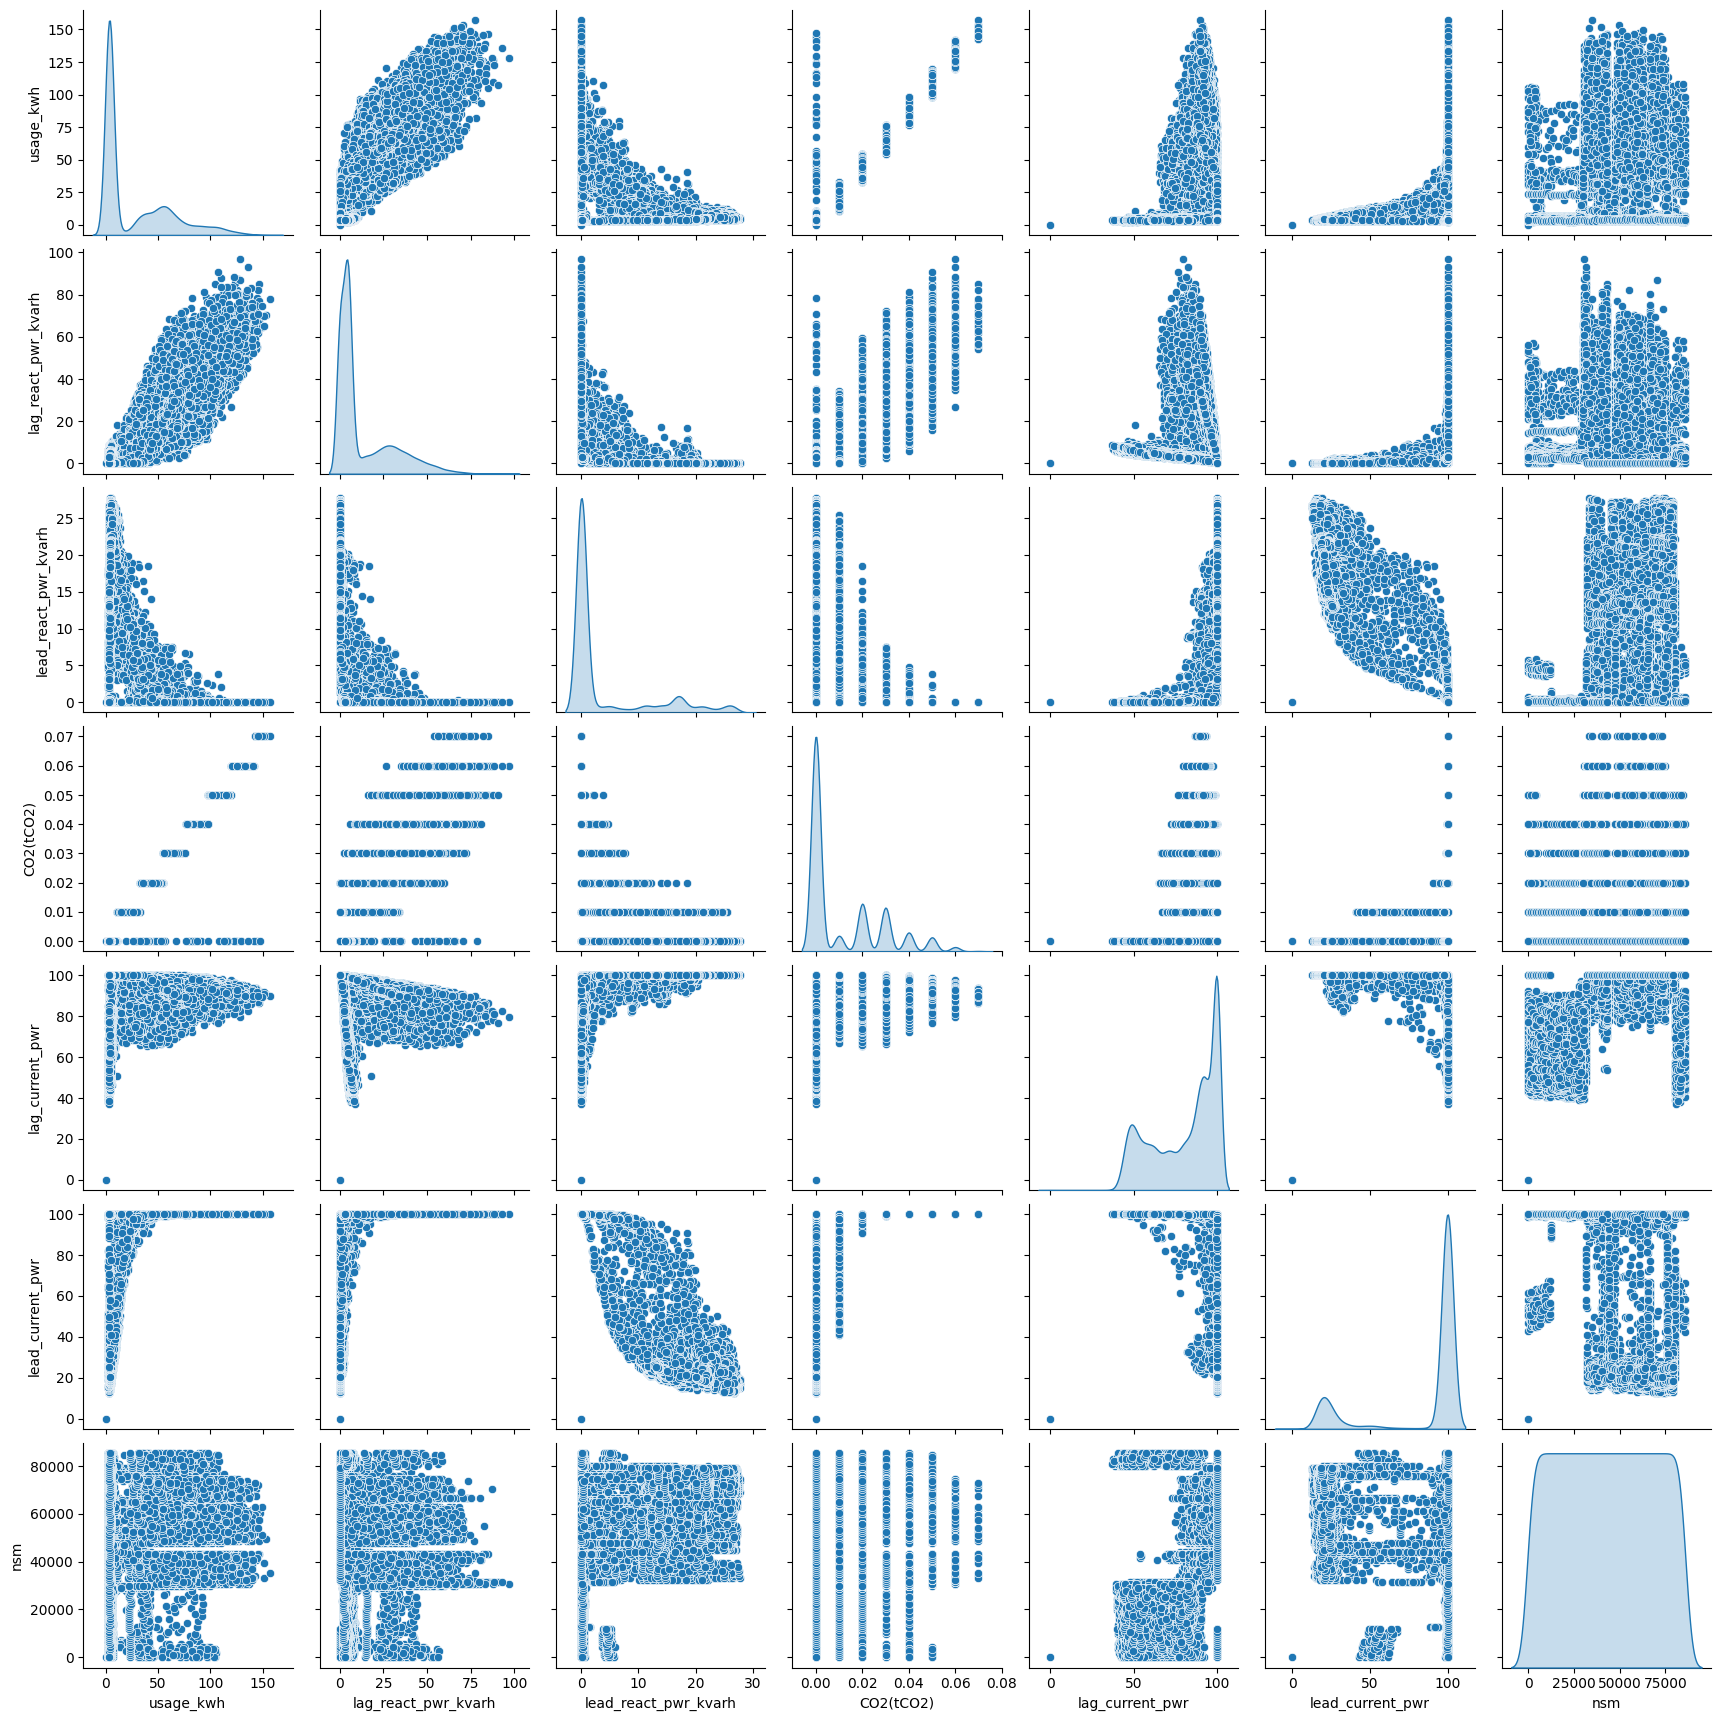

In [15]:
sns.pairplot(df,diag_kind="kde")

These plots appear to come in several categories. A lot of them include values that tend to hug both axes, which can be explained by the fact that a lot of the columns have values of 0.0 or at least very, very small values compared to the scale of the pairplot. There are also lots of plots that appear to just be jumbled up data with very little correlation. A few of these plots look more linear than others and might have a stronger correlation. Finally, there are 4 plots that look like they have linear correlation: usage_kwh vs lag_react_pwr_kvarh and vice versa as well as lead_react_pwr_kvarh vs lead_current_pwr and vice versa. This makes sense because the columns correspond to one another anyway.

### Splitting Data into Train/Test

In [16]:
X = df[['lag_react_pwr_kvarh','lead_react_pwr_kvarh','CO2(tCO2)','lag_current_pwr','lead_current_pwr','nsm','week_status','day_of_week','load_type']]
y = df['usage_kwh']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

### Building the Pipeline

In [18]:
df.dtypes

date                     object
usage_kwh               float64
lag_react_pwr_kvarh     float64
lead_react_pwr_kvarh    float64
CO2(tCO2)               float64
lag_current_pwr         float64
lead_current_pwr        float64
nsm                       int64
week_status              object
day_of_week              object
load_type                object
dtype: object

In [19]:
num_attribs = ['lag_react_pwr_kvarh','lead_react_pwr_kvarh','CO2(tCO2)','lag_current_pwr','lead_current_pwr','nsm']
cat_attribs = ['week_status', 'day_of_week','load_type']

In [20]:
col_transform = ColumnTransformer(transformers=[
                               ('cat',OneHotEncoder(), cat_attribs),
                               ('num',MinMaxScaler(), num_attribs),],
                  )

In [21]:
pipeline = Pipeline([
                     ('transform', col_transform),
                     ('model', LinearRegression()),
])

### Executing the Model

In [22]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['week_status', 'day_of_week',
                                                   'load_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'CO2(tCO2)',
                                                   'lag_current_pwr',
                                                   'lead_current_pwr',
                                                   'nsm'])])),
                ('model', LinearRegression())])

### Evaluating Model

In [23]:
y_pred= pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

In [24]:
print(mean_squared_error(y_train, y_train_pred)**(0.5))
print(mean_squared_error(y_test, y_pred)**(0.5))

4.58316622126044
5.049590596342929


These values are fairly comparable. They aren't super super close but they are less than 0.5 apart, which means the values are pretty consistent between the testing set and the training set.

In [25]:
r2_score(y_pred, y_test)

0.976289382780047

The value here indicates that this model is an excellent predictor and a fantastic fit. The value is almost as close to 1 as it can be, capturing almost 98% of the variation.

In [26]:
pipeline.named_steps['model'].intercept_

344915748065639.4

In [27]:
pipeline.named_steps['model'].coef_

array([-5.08872671e+13, -3.90983168e+13, -6.89619855e+13, -6.89619855e+13,
       -8.07509358e+13, -8.07509358e+13, -6.89619855e+13, -6.89619855e+13,
       -6.89619855e+13, -2.25066496e+14, -2.25066496e+14, -2.25066496e+14,
        2.90083845e+01,  1.91419272e+00,  1.17473851e+02,  6.99739086e+00,
        4.74945300e+00, -3.54024887e-01])

### Conclusion
This model appears to be very suitable for predicting kwh usage. With an r^2 score as high as 0.976, we can be certain the model is at least one of the ones for the job. The RMSE values between the training and testing values are close enough too to suggest very little variation between the two.

## Problem 2

### Reading the Data

In [28]:
df['week_status'] = df['week_status'].apply(lambda x: 1 if x == "Weekday" else 0)

### Splitting Data into Train/Test

In [29]:
X = df[['usage_kwh','lag_react_pwr_kvarh','lead_react_pwr_kvarh','CO2(tCO2)','lag_current_pwr','lead_current_pwr','nsm','load_type']]
y = df['week_status']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=32)

### Building the Pipeline

In [31]:
num_attribs = ['usage_kwh','lag_react_pwr_kvarh','lead_react_pwr_kvarh','CO2(tCO2)','lag_current_pwr','lead_current_pwr','nsm']
cat_attribs = ['load_type']

In [32]:
col_transform = ColumnTransformer(transformers=[
                               ('cat',OneHotEncoder(), cat_attribs),
                               ('num',MinMaxScaler(), num_attribs),],
                  )

In [33]:
pipeline = Pipeline([
                     ('transform', col_transform),
                     ('model', LogisticRegression(max_iter=1000)),
])

### Executing the Model

In [34]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['load_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['usage_kwh',
                                                   'lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'CO2(tCO2)',
                                                   'lag_current_pwr',
                                                   'lead_current_pwr',
                                                   'nsm'])])),
                ('model', LogisticRegression(max_iter=1000))])

### Evaluating Model

In [35]:
y_pred= pipeline.predict(X_test)

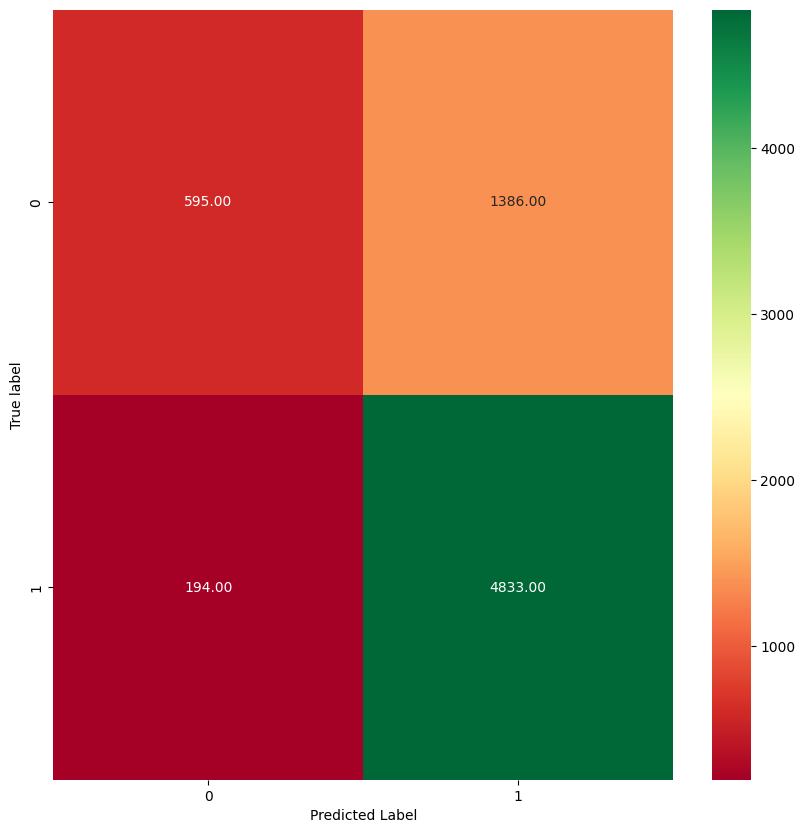

In [36]:
plot_cm(y_test,y_pred)

In [37]:
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.7771345875542692
0.9614083946687886
0.8595056019918195


These values tell us the model was fantastic at predicting the 1s, which are the weekdays. This makes sense, as most of the data values are going to be a weekday in general, but this is still a superb score and it means the model is great at this function. The precision score wasn't as impressive, but the value wasn't terrible by any means. This means it's less successful at predicting weekends. The harmonic mean was also fairly high which is a good sign for both values.

0.7751473692740675


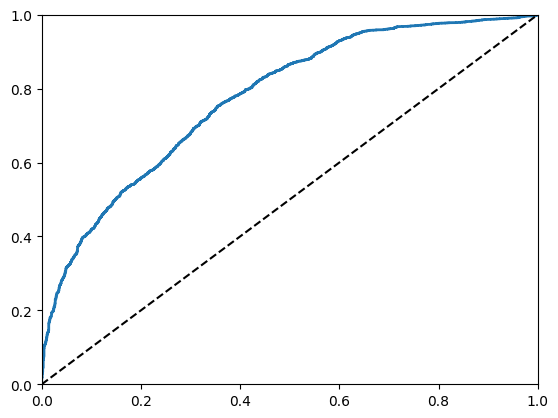

In [42]:
y_pred_proba = pipeline.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,y_pred_proba)
plot_roc_curve(fpr, tpr)
print(roc_auc_score(y_test, y_pred_proba))

This AUC value is decent. It means more often than not, the model is going to correctly predict the binary values (weekdays vs weekends). It could certainly be better (the preference would be closer to 0.9), but overall this means it got the result right most of the time. I picked the ROC Curve to plot because it's more appropriate when dealing with binary results.

### Conclusion
The logistic regression model seems to be fairly well-suited for predicting whether the data represents a week day or weekend day. While not as impressive as the linear model in Problem 1, this model still scored high in every attribute. With a super high recall score (meaning it's fantastic at predicting the positive values) and a higher than average precision score, f1 score, and AUC value, this model's predictions lined up pretty close to the test values sampled, meaning the logistic regression model is a great one to use in this scenario.